[*********************100%%**********************]  2 of 2 completed


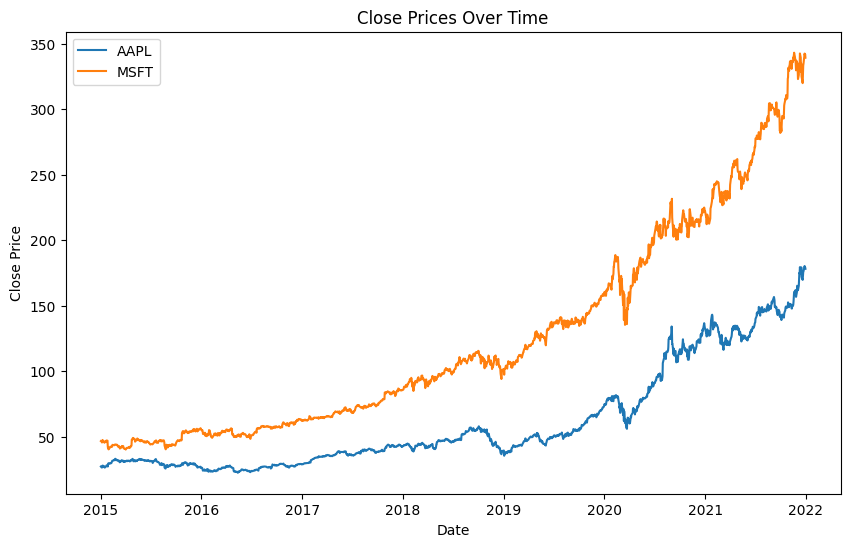

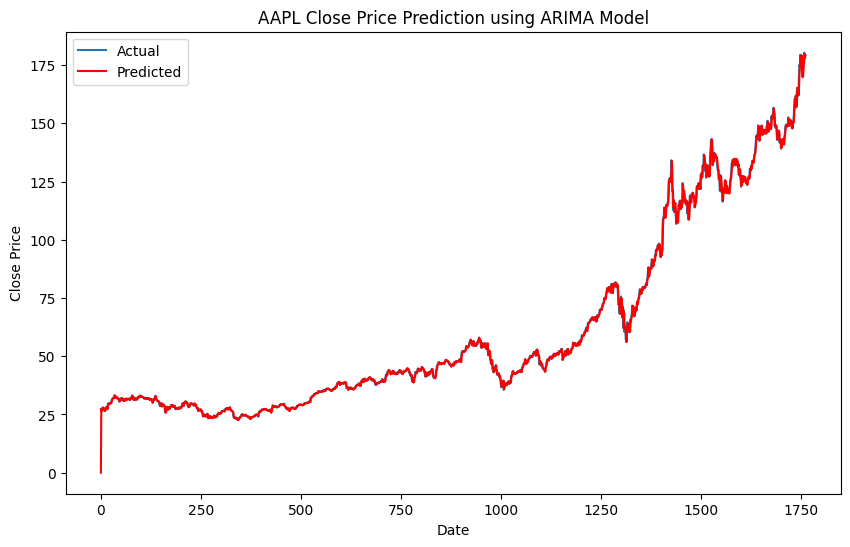

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


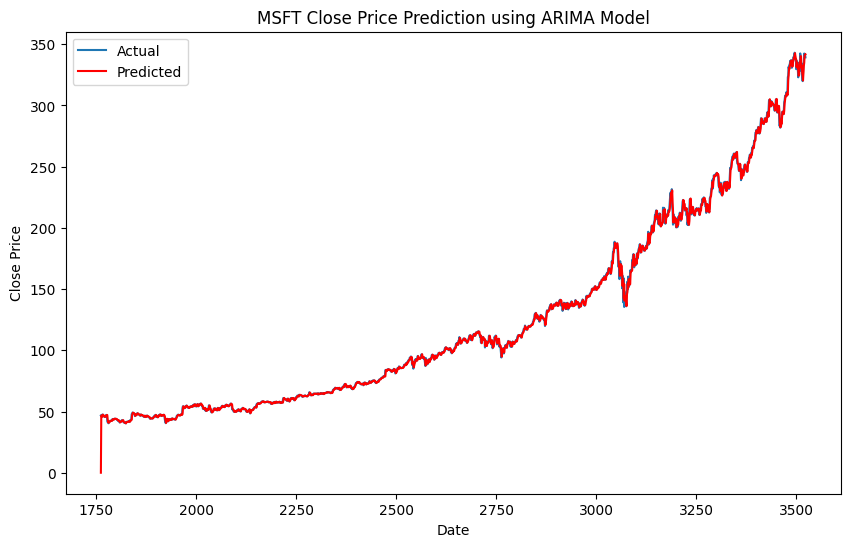

In [76]:
!pip install yfinance
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Define the ticker symbols
tickers = ['AAPL', 'MSFT']

# Fetch data
stock_data = yf.download(tickers, start='2015-01-01', end='2021-12-31')

# Extract the "Close" prices
close = stock_data["Close"]

# Reformatting the DataFrame
reformatted_close = close.reset_index().melt(id_vars=['Date'], var_name='Ticker', value_name='Close')

# Plotting the reformatted data
plt.figure(figsize=(10, 6))
for ticker in tickers:
    ticker_data = reformatted_close[reformatted_close['Ticker'] == ticker]
    plt.plot(ticker_data['Date'], ticker_data['Close'], label=ticker)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Prices Over Time')
plt.legend()

# Show the plot
plt.show()

# Fit ARIMA model
for ticker in tickers:
    ticker_data = reformatted_close[reformatted_close['Ticker'] == ticker]['Close']
    model = ARIMA(ticker_data, order=(5,1,0))
    model_fit = model.fit()

    # Make predictions
    predictions = model_fit.predict(start=0, end=len(ticker_data)-1)

    # Plotting the original data and the predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(ticker_data.index, ticker_data, label='Actual')
    plt.plot(ticker_data.index, predictions, label='Predicted', color='red')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.title(f'{ticker} Close Price Prediction using ARIMA Model')
    plt.legend()
    plt.show()

In [77]:
forecast = model_fit.forecast(steps=100)
forecast

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


1762    339.621886
1763    339.412047
1764    339.399232
1765    339.460301
1766    339.469841
           ...    
1857    339.473179
1858    339.473179
1859    339.473179
1860    339.473179
1861    339.473179
Name: predicted_mean, Length: 100, dtype: float64

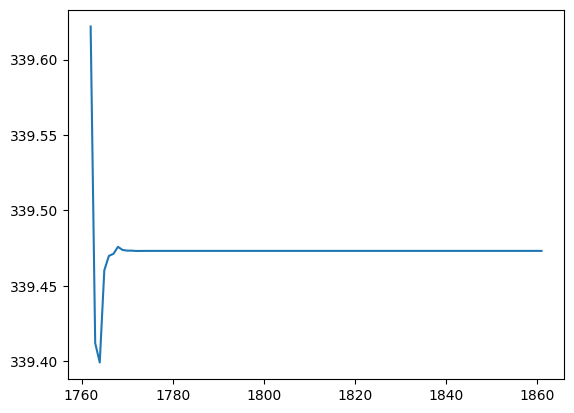

In [78]:
plt.plot(forecast)
plt.show()

[*********************100%%**********************]  2 of 2 completed


Epoch 1/100
19/19 [==============================] - 7s 146ms/step - loss: 0.0380 - val_loss: 0.0603
Epoch 2/100
19/19 [==============================] - 1s 54ms/step - loss: 0.0047 - val_loss: 0.0067
Epoch 3/100
19/19 [==============================] - 1s 47ms/step - loss: 0.0015 - val_loss: 0.0031
Epoch 4/100
19/19 [==============================] - 1s 41ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 5/100
19/19 [==============================] - 1s 37ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 6/100
19/19 [==============================] - 1s 37ms/step - loss: 9.4828e-04 - val_loss: 0.0012
Epoch 7/100
19/19 [==============================] - 1s 37ms/step - loss: 9.8553e-04 - val_loss: 0.0021
Epoch 8/100
19/19 [==============================] - 1s 50ms/step - loss: 8.9204e-04 - val_loss: 0.0013
Epoch 9/100
19/19 [==============================] - 1s 43ms/step - loss: 9.2909e-04 - val_loss: 0.0020
Epoch 10/100
19/19 [==============================] - 1s 38ms/step - loss: 8.5371e-

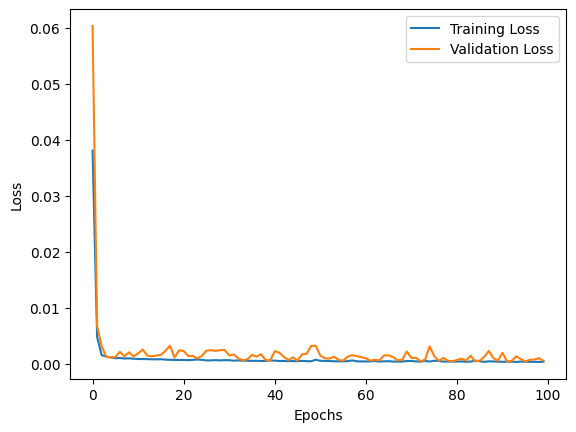

5/5 [==============================] - 1s 12ms/step


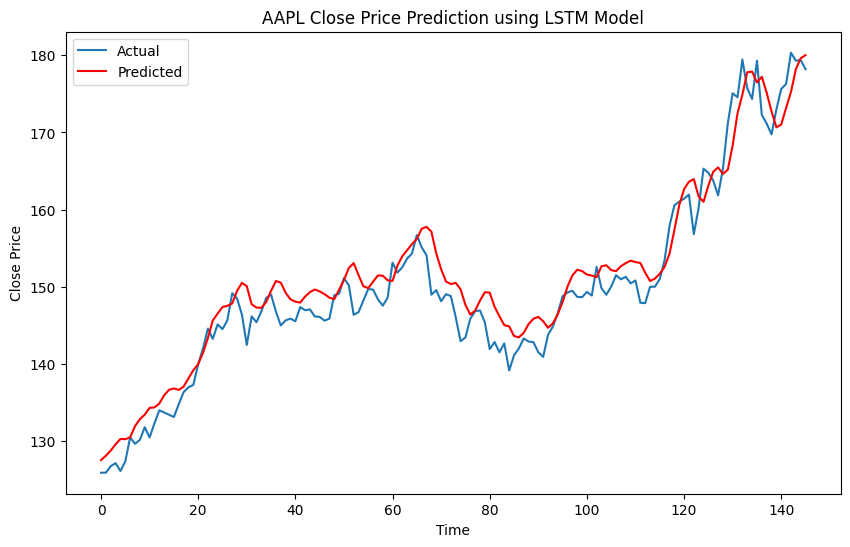

In [79]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define the ticker symbols
tickers = ['AAPL', 'MSFT']

# Fetch data
stock_data = yf.download(tickers, start='2019-01-01', end='2021-12-31')

# Extract the "Close" prices
close = stock_data["Close"]

# Reformatting the DataFrame
reformatted_close = close.reset_index().melt(id_vars=['Date'], var_name='Ticker', value_name='Close')

# Choose a single stock to model (let's use AAPL for example)
ticker_data = reformatted_close[reformatted_close['Ticker'] == 'AAPL']

# Convert 'Close' prices to numpy array
close_prices = ticker_data['Close'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close_prices = scaler.fit_transform(close_prices)

# Prepare the data for LSTM model
def prepare_data(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

time_steps = 30  # Number of time steps to look back
X, y = prepare_data(scaled_close_prices, time_steps)

# Reshape data for LSTM (samples, time steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(units=50, return_sequences=False),
    Dense(units=25),
    Dense(units=1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_test, y_test))

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions and actual values
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plotting the actual and predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted', color='red')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('AAPL Close Price Prediction using LSTM Model')
plt.legend()
plt.show()